In [1]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

# Fix python anemia distribution code

### This notebook was created to identify and correct a discrepancy between an ensemble distribution sampled via R code and what should have been the same distribution implemented in python code.

### The ensemble distribution is composed of both gamma and mirrored_gumbel distributions. The gamma portion of the distributions was identical in the 2017 code. However, the gumbel distributions did not match. The 2017 gumbel code is shown below (_mirrored_gumbel_ppf_2017) and the new implementation is directly above.

### Using the new python code both the gamma and gumbel distributions are the same as their R counterparts.

In [2]:
%load_ext rpy2.ipython

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

In [4]:
def _gamma_ppf(propensity, mean, sd):
    shape = (mean / sd)**2
    scale = sd**2 / mean
    return scipy.stats.gamma(a=shape, scale=scale).ppf(propensity)

def _mirrored_gumbel_ppf(propensity, mean, sd):
    x_max = 220 # data_values.HEMOGLOBIN_DISTRIBUTION.EXPOSURE_MAX
    _alpha = x_max - mean - (sd * np.euler_gamma * np.sqrt(6) / np.pi)
    scale = sd * np.sqrt(6) / np.pi
    tmp = _alpha + (scale*np.euler_gamma)
    alpha = _alpha + x_max - (2*tmp)
    return scipy.stats.gumbel_r(alpha, scale=scale).ppf(propensity)

def _mirrored_gumbel_ppf_2017(propensity, mean, sd):
    x_max = 220 # data_values.HEMOGLOBIN_DISTRIBUTION.EXPOSURE_MAX
    alpha = x_max - mean - (sd * np.euler_gamma * np.sqrt(6) / np.pi)
    scale = sd * np.sqrt(6) / np.pi
    return x_max - scipy.stats.gumbel_r(alpha, scale=scale).ppf(1 - propensity)

'''
def viv_calc_iron(propensity1, propensity2, mean, sd):
  if propensity1 < 0.4:
    exposure = _gamma_ppf( propensity2, mean, sd )
  else:
    exposure = _mirrored_gumbel_ppf( propensity2, mean, sd)
  return exposure
'''

def viv_calc_iron_nbs(prop_dist, propensity, exposure_parameters):
    #propensity = clip(propensity)
    exposure_data = exposure_parameters
    mean = exposure_data['mean']
    sd = exposure_data['sd']

    gamma = prop_dist < 0.4
    gumbel = ~gamma
    ret_val = pd.Series(index=prop_dist.index, name='value')
    ret_val.loc[gamma] = _gamma_ppf(propensity.loc[gamma], mean, sd)
    ret_val.loc[gumbel] = _mirrored_gumbel_ppf(propensity.loc[gumbel], mean, sd)
    return ret_val

def viv_calc_iron(propensity, exposure_parameters):
    #propensity = clip(propensity)
    exposure_data = exposure_parameters
    mean = exposure_data['mean']
    sd = exposure_data['sd']
    exposure = (0.4 * _gamma_ppf(propensity, mean, sd)
                + 0.6 * _mirrored_gumbel_ppf(propensity, mean, sd))
    return pd.Series(exposure, index=propensity.index, name='value')

def viv_calc_iron_2017(propensity, exposure_parameters):
    #propensity = clip(propensity)
    exposure_data = exposure_parameters
    mean = exposure_data['mean']
    sd = exposure_data['sd']
    exposure = (0.4 * _gamma_ppf(propensity, mean, sd)
                + 0.6 * _mirrored_gumbel_ppf_2017(propensity, mean, sd))
    return pd.Series(exposure, index=propensity.index, name='value')


In [5]:
p = pd.Series(np.random.uniform(size=100))
df = pd.DataFrame({'myvals': [1 for i in range(100)], 'prop': p})
gamma = df.prop < 0.4
gumbel = ~gamma
df.loc[gamma] *= 0.4
pd.Series(index=p.index, name='value').loc[gumbel] = 10

In [6]:
def _mirrored_gumbel_test(mean, sd):
    x_max = 220 # data_values.HEMOGLOBIN_DISTRIBUTION.EXPOSURE_MAX
    alpha = x_max - mean - (sd * np.euler_gamma * np.sqrt(6) / np.pi)
    scale = sd * np.sqrt(6) / np.pi
    return alpha, scale

_mirrored_gumbel_test(120, 15)

(93.24920188681457, 11.69545201850514)

In [7]:
%%R
set.seed(43)

# import standard R functions for the gamma distributions (pgamma and rgamma)
pacman::p_load(data.table,actuar)

# define constants
XMAX = 220
EULERS_CONSTANT = 0.57721566490153286060651209008240243104215933593992
w = c(0.4,0.6)

# function to calculate gamma distribution parameters from mean and variance
gamma_mv2p = function(mn, vr){
  list(shape = mn^2/vr,rate = mn/vr)
}

# function to calculate mirror gumbel distribution parameters from mean and variance
mgumbel_mv2p = function(mn, vr){
  list(
    alpha = XMAX - mn - EULERS_CONSTANT*sqrt(vr)*sqrt(6)/pi,
    scale = sqrt(vr)*sqrt(6)/pi)
}

# function to randomly sample n times from mirror gumbel distribution
rmgumbel = function(n, alpha, scale){
  mn = alpha + scale*EULERS_CONSTANT
  rgumbel(n, alpha+XMAX-(2*mn), scale)
}

# function to sample from ensemble hemoglobin distribution using functions defined above
  # n = number of samples to take
  # mn = mean hemoglobin concentration
  # vr = hemoglobin distribution variance (standard deviation squared)
  # w = list of ensemble distribution weights c(gamma_weight, mirror_gumbel_weight)
sample_from_hemoglobin_distribution <- function(n, mn, vr, w){

  ##parameters
  params_gamma = gamma_mv2p(mn, vr)
  params_mgumbel = mgumbel_mv2p(mn, vr)

  ##weighting
  sample_list = sum(
    w[1] * rgamma(n, params_gamma$shape, params_gamma$rate),
    w[2] * rmgumbel(n, params_mgumbel$alpha, params_mgumbel$scale)
  )
  sample_list
}


In [8]:
%%R
# alpha = 93.249202 scale = 11.695452"
mn = 93.249202 + 11.695452*EULERS_CONSTANT
arg = 93.249202+220-(2*mn)
arg

[1] 113.2492


In [9]:
%%R
# Look at what the individual equations produce

gamma_params = gamma_mv2p(120, 225)
print(sprintf("shape = %f rate = %f", gamma_params$shape, gamma_params$rate))

print(sprintf("rgamma = %f", mean(rgamma(1000, shape=64, rate=0.5333333))))

mg_params = mgumbel_mv2p(120, 225)
print(sprintf("mgparams: alpha = %f scale = %f", mg_params$alpha, mg_params$scale))
print(sprintf("mirror_gumbel (above params) = %f", rmgumbel(1, mg_params$alpha, mg_params$scale)))

[1] "shape = 64.000000 rate = 0.533333"
[1] "rgamma = 120.324350"
[1] "mgparams: alpha = 93.249202 scale = 11.695452"
[1] "mirror_gumbel (above params) = 131.236336"


In [10]:
#alpha = x_max - mean - (sd * np.euler_gamma * np.sqrt(6) / np.pi)
alpha = 220 - 120 - (15 * np.euler_gamma * np.sqrt(6) / np.pi)

#scale = sd * np.sqrt(6) / np.pi
scale = 15 * np.sqrt(6) / np.pi

print(f'alpha = {alpha} scale = {scale}')

alpha = 93.24920188681457 scale = 11.69545201850514


In [11]:
q = np.linspace(0.1, 0.9, 1000)

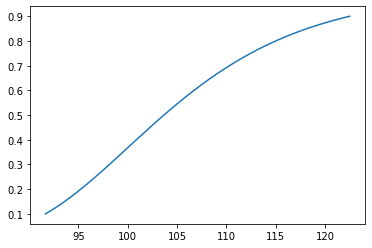

In [12]:
import matplotlib.pyplot as plt
x_python = scipy.stats.gumbel_r(loc=100, scale=10).ppf(q)
plt.plot(x_python, q)

# This shows that identically parameterized functions:

 - python (scipy.stats.gumbel_r)
 
 - R (qgumbel) 
  
# produce identical results.

In [13]:
%%R -i q -o rdf_gum
gvals = qgumbel(q, 100, 10)
rdf_gum <- data.frame(gvalues = gvals)

/home/kjells/miniconda3/envs/run_r/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


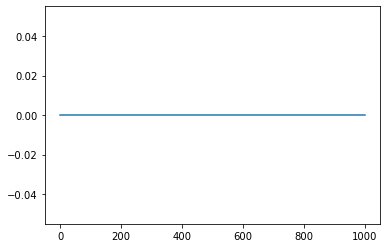

In [14]:
x_r = rdf_gum.gvalues.values
plt.plot(x_python - x_r)

In [15]:
np.random.seed(43)
prop = np.random.uniform(size=10000)
prop[:20]

array([0.11505457, 0.60906654, 0.13339096, 0.24058962, 0.32713906,
       0.85913749, 0.66609021, 0.54116221, 0.02901382, 0.7337483 ,
       0.39495002, 0.80204712, 0.25442113, 0.05688494, 0.86664864,
       0.221029  , 0.40498945, 0.31609647, 0.0766627 , 0.84322469])

In [16]:
%%R -i prop -o rdf_gum
gvals = qgumbel(prop, 113.2492, 11.695452)
rdf_gum <- data.frame(gvalues = gvals)

/home/kjells/miniconda3/envs/run_r/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [17]:
%%R -i prop -o rdf_gamma
vals = qgamma(prop, shape=64, rate=0.5333333)
rdf_gamma <- data.frame(values = vals)

In [18]:
gum_vals = pd.Series(_mirrored_gumbel_ppf(prop, 120, 15))
gum_vals_2017 = pd.Series(_mirrored_gumbel_ppf_2017(prop, 120, 15))

In [19]:
gamma_vals = pd.Series(_gamma_ppf(prop, 120, 15))

In [20]:
print(f'R gumbel overview:\n{rdf_gum.describe()}\n')
print(f'Python gumbel overview:\n{gum_vals.describe()}\n')
print(f'Python gumbel 2017 overview (notice the almost identical mean but otherwise very different values):\n{gum_vals_2017.describe()}')

R gumbel overview:
            gvalues
count  10000.000000
mean     120.293465
std       15.061654
min       86.878132
25%      109.714645
50%      117.890049
75%      128.282924
max      243.116532

Python gumbel overview:
count    10000.000000
mean       120.293467
std         15.061654
min         86.878134
25%        109.714647
50%        117.890051
75%        128.282926
max        243.116534
dtype: float64

Python gumbel 2017 overview (notice the almost identical mean but otherwise very different values):
count    10000.000000
mean       120.252235
std         15.120974
min         15.252409
25%        112.633956
50%        122.815316
75%        130.856126
max        154.905424
dtype: float64


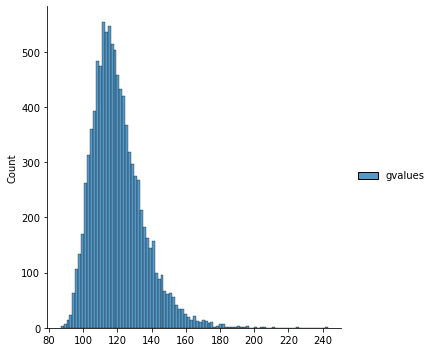

In [21]:
sns.displot(rdf_gum)

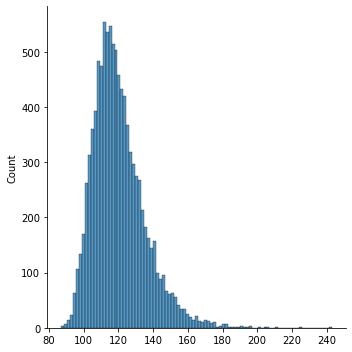

In [22]:
sns.displot(gum_vals)

In [23]:
print(f'Stats from R gamma = {rdf_gamma.describe()}\nStats from scipy gamma = {gamma_vals.describe()}')

Stats from R gamma =              values
count  10000.000000
mean     120.303681
std       15.050801
min       71.189667
25%      109.946079
50%      119.767773
75%      130.170979
max      193.096345
Stats from scipy gamma = count    10000.000000
mean       120.303673
std         15.050800
min         71.189662
25%        109.946072
50%        119.767765
75%        130.170971
max        193.096333
dtype: float64


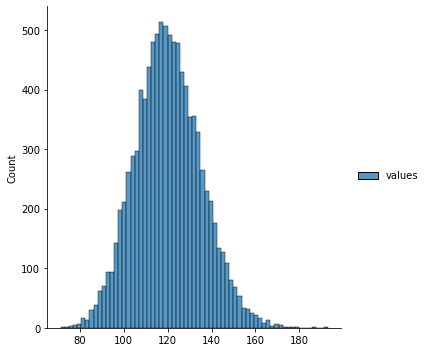

In [24]:
sns.displot(rdf_gamma)

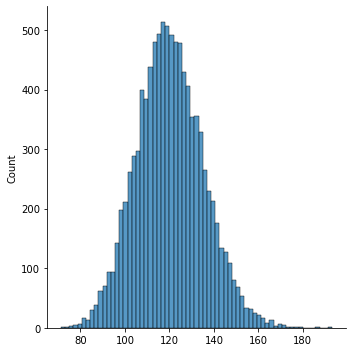

In [25]:
sns.displot(gamma_vals)

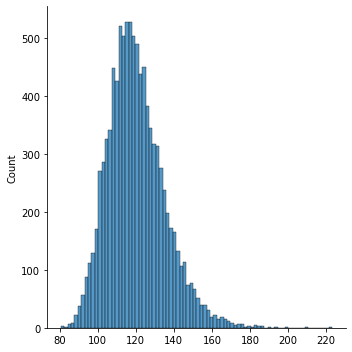

In [26]:
ensemble = 0.4 * gamma_vals + 0.6 * gum_vals
sns.displot(ensemble)

In [27]:
ens_calc = viv_calc_iron(pd.Series(prop), pd.DataFrame({'mean': [120], 'sd': [15]}))
np.random.seed(113)
prop_dist = np.random.uniform(size=10000)
nbs_calc = viv_calc_iron_nbs(pd.Series(prop_dist), pd.Series(prop), pd.DataFrame({'mean': [120], 'sd': [15]}))

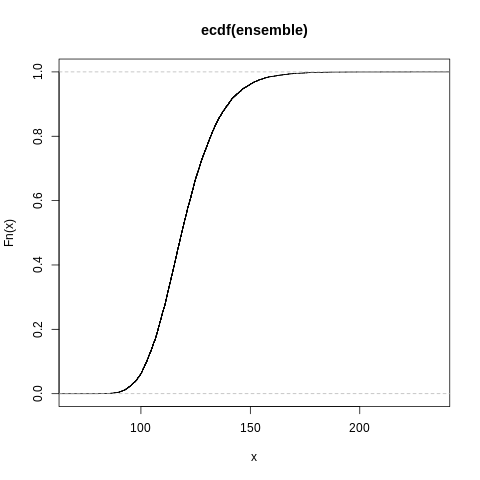

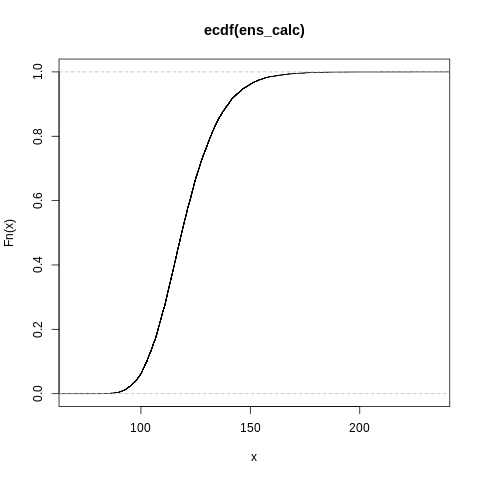

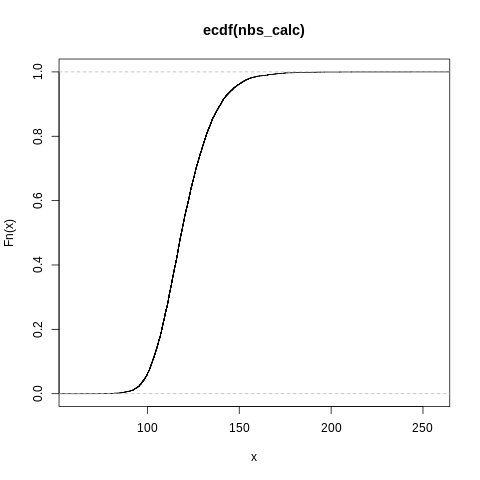

In [28]:
%%R -i ensemble -i ens_calc -i nbs_calc
plot(ecdf(ensemble))
plot(ecdf(ens_calc))
plot(ecdf(nbs_calc))

In [29]:
print(ens_calc.describe())
print(nbs_calc.describe())

count    10000.000000
mean       120.297549
std         14.990119
min         80.602745
25%        109.807217
50%        118.641137
75%        129.038144
max        223.108454
Name: value, dtype: float64
count    10000.000000
mean       120.293301
std         15.112655
min         73.396963
25%        109.792867
50%        118.516060
75%        129.079698
max        243.116534
Name: value, dtype: float64
